<a href="https://colab.research.google.com/github/akiwo/pokemon_reinforcement_learning/blob/jupyter/%E3%83%9D%E3%82%B1%E3%83%A2%E3%83%B3%E5%AF%BE%E6%88%A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#基本データの読み込み

In [187]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dex.csv to dex (1).csv
User uploaded file "dex.csv" with length 927 bytes


In [188]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving moves.csv to moves (1).csv
User uploaded file "moves.csv" with length 3879 bytes


#強化学習の設定

## Agent
実際に行動を決定するエージェントのクラス

### 基本クラス
オーバーライドして使う、基本のメソッドだけ設定するクラス

In [0]:
#coding: utf-8

import sys
import pickle
import random
import numpy as np
import math
from collections import defaultdict

#import importlib
#importlib.reload(sys)
#sys.setdefaultencoding("utf-8")

class ELAgent(object):

    def __init__(self, epsilon):
        self.q = defaultdict(lambda: defaultdict(float))
        self.N = defaultdict(lambda: defaultdict(int))
        self.epsilon = epsilon

    def save(self, model_path):
        f = open(model_path,'w')
        save_data = ["hoge"]
        pickle.dump(save_data,f)
        f.close()

    @classmethod
    def load(cls, model_path):
        f = open(model_path, 'r')
        save_data = pickle.load(f)
        f.close()
        return save_data
        
    def Q(self,states,action):
        qa = self.q[action]
        return sum([qa[sk]*sv for sk,sv in states])
        
    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def policy(self, s, actions):
        if np.random.random() < self.epsilon:
            return random.choice(list(actions))
        else:
            #choose max one(if there are equal values, choose one from those randomly)
            np.random.shuffle(list(actions))
            return max(actions, key = lambda a: self.Q(s,a))
    def log(self, reward):
        self.reward_log.append(reward)

    def show_reward_log(self, interval=50, episode=-1):
        pass
     


### Q学習クラス
線形接続で期待値を計算する、Q学習のクラス

memo: learning_rateは0.1程度に設定していたとき、まともに動作しなかった。
おそらく学習率が高すぎ。
0.01程度にすると、100回ほど実行すれば学習が完了する。

In [0]:
class QLearningAgent(ELAgent):

    def __init__(self, epsilon=0.1):
        super(QLearningAgent, self).__init__(epsilon)

    def learn_one_episode(self, experience, gamma=0.90, render=False, report_interval=50):
        for step in experience[::-1]: #reverse
            self.learn_one_step(step, gamma, learning_rate = 0.01)
        
    def learn_one_step(self,step, gamma = 0.90, learning_rate = 0.01):
        rewards = [sum([r for s,a,a_s,r in step[i+1:]]) for i in range(len(step))] #その状態以降の合計
        sar = [(state,action,actions,reward) for ((state,action,actions,r),reward) in zip(step,rewards) if len(state)]
        sasr = [(state,action,next_state,next_actions,reward-nr) for ((state,action,a_s,reward),(next_state,na,next_actions,nr)) in zip(sar[:-1],sar[1:])] #次状態の報酬を引くことで、次の状態までに得た報酬を値にしている

        #逆順に学習
        for state,action,next_state,next_actions,reward in sasr[::-1]:
            for sk,sv in state:
                self.N[action][sk] += sv  # count of s,a pair

            gain = reward + gamma * max([self.Q(next_state,next_action) for next_action in next_actions])
            estimated = self.Q(state,action)
            for sk,sv in state:
                self.q[action][sk] += learning_rate * (gain - estimated) * sv

### モンテカルロエージェント
前に使っていたが、今は未実装。動かないはず。

In [0]:
class MonteCarloAgent(ELAgent):

    def __init__(self, epsilon=0.1):
        super(MonteCarloAgent, self).__init__(epsilon)

        self.init_log()
        self.Q = defaultdict(lambda: defaultdict(float))
        self.N = defaultdict(lambda: defaultdict(int))

    def learn_one_episode(self, steps, gamma=0.90, render=False, report_interval=50):
        #episode: list of {"state":State, "action":Action, "reward":}
        experience = []
        for step in steps:
            experience += step[:-1]

        # Evaluate each state, action.
        for i, x in enumerate(experience):
            s, a = x[0], x[1]
            if s == None: #rewardの行を開始点として計算することはない
                continue

            # Calculate discounted future reward of s.
            G, t = 0, 0
            for j in range(i, len(experience)):
                if experience[j][0] == None: #rewardのみ計算
                    G += math.pow(gamma, t) * experience[j][2]
                    t += 1

            self.N[tuple(s)][a] += 1  # count of s, a pair
            alpha = 1 / self.N[tuple(s)][a]
            self.Q[tuple(s)][a] += alpha * (G - self.Q[tuple(s)][a])
    def learn_one_step(self,step, gamma = 0.90, learning_rate = 0.1):
        pass

### ランダム動作エージェント
比較対象用の、ランダムに行動を選択するエージェント。

In [0]:
class RandomAgent(ELAgent):

    def __init__(self, epsilon=0.1):
        super(RandomAgent, self).__init__(epsilon)

    def policy(self, s, actions):
        return random.choice(list(actions))

    def learn_one_episode(self, experience, gamma=0.90, render=False, report_interval=50):
        for step in experience[::-1]: #reverse
            self.learn_one_step(step, gamma, learning_rate = 0.1)
            
    def learn_one_step(self,step, gamma = 0.90, learning_rate = 0.1):
        rewards = [sum([r for s,a,a_s,r in step[i+1:]]) for i in range(len(step))] #その状態以降の合計
        sar = [(state,action,actions,reward) for ((state,action,actions,r),reward) in zip(step,rewards) if len(state)]
        sasr = [(state,action,next_state,next_actions,reward) for ((state,action,a_s,reward),(next_state,na,next_actions,nr)) in zip(sar[:-1],sar[1:])]

        #逆順に学習
        for state,action,next_state,next_actions,reward in sasr[::-1]:
            for sk,sv in state:
                self.N[action][sk] += sv  # count of s, a pair

### Deep Q-Learningエージェント

In [0]:
class DeepQLearningAgent(ELAgent):

    def __init__(self, epsilon=0.1):
        super(DeepQLearningAgent, self).__init__(epsilon)

    def learn_one_episode(self, experience, gamma=0.90, render=False, report_interval=50):
        for step in experience[::-1]: #reverse
            self.learn_one_step(step, gamma, learning_rate = 0.01)
        
    def learn_one_step(self,step, gamma = 0.90, learning_rate = 0.01):
        rewards = [sum([r for s,a,a_s,r in step[i+1:]]) for i in range(len(step))] #その状態以降の合計
        sar = [(state,action,actions,reward) for ((state,action,actions,r),reward) in zip(step,rewards) if len(state)]
        sasr = [(state,action,next_state,next_actions,reward-nr) for ((state,action,a_s,reward),(next_state,na,next_actions,nr)) in zip(sar[:-1],sar[1:])] #次状態の報酬を引くことで、次の状態までに得た報酬を値にしている

        #逆順に学習
        for state,action,next_state,next_actions,reward in sasr[::-1]:
            for sk,sv in state:
                self.N[action][sk] += sv  # count of s,a pair

            gain = reward + gamma * max([self.Q(next_state,next_action) for next_action in next_actions])
            estimated = self.Q(state,action)
            for sk,sv in state:
                self.q[action][sk] += learning_rate * (gain - estimated) * sv

## Teacher(Trainer)
学習用のクラス。
Trainerだとポケモントレーナーとかぶるので、Teacherクラスとしている。

In [0]:
#書籍ではクラス名がTrainerとなっているが、クラス名が被るためTeacherに変更
class Teacher(object):
    def __init__(self, buffer_size=1024, batch_size=32, gamma=0.9, report_interval = 10, log_dir=""):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.report_interval = report_interval
        
        self.logger = Logger(log_dir, self.teacher_name)
        self.experiences = []
        self.training = False
        self.training_count = 0
        self.reward_log = []
    @property
    def teacher_name(self):
        return "teacher"

    def add_experience(self,experience):
        self.experiences.append(experience)

    def teach_agent(self, agent):
        for experience in self.experiences:
            agent.learn_one_episode(self, experience, gamma=self.gamma)


## Observer
観測データを活用可能に加工するクラス。未実装

In [0]:
class Observer(object):
    def __init__(self,env):
        self._env = env
    @property
    def action_space(self):
        return self._env.action_space
    @property
    def observation_space(self):
        return self._env.observation_space
    def reset(self):
        return self.transform(self._env.reset())
    def render(self):
        self._env.render(mode="human")
    def step(self,action):
        n_state, reward, done, info = self._env.step(action)
        return self.transform(n_state), reward, done, info
    def transform(self, state):
        pass

### 育成Observer
6匹のチーム編成用のオブザーバークラス
* 特徴量
  * 選択済みポケモン名
    * フォルムやわざの情報は使っていない

In [0]:
class BreedObserver(Observer):
    def transform(self,state):
        
        s = {}
        s[""] = 1.0 #切片

        for st in state:
            s[st[0]] = 1.0
        
        #remove key if the value is 0.
        s = {k:v for k,v in s.items() if v != 0.0}
            
        return s.items()

### 対戦Observer
対戦時の行動決定用のオブザーバークラス
* 特徴量
  * 自分のチームの全ポケモン(フォルム含む)(選出されていないポケモン含む)
  * 相手のチームの全ポケモン(フォルム含む)(選出されていないポケモン含む)
  * 自分の戦闘中のポケモンがひんし状態か
  * 自分の戦闘中のポケモン
  * 相手の戦闘中のポケモン
  * 自分の控えポケモン
    * 既に登場済みか(相手にバレているか)
  * 相手の控えポケモン
    * 不明の場合Unknownとする(Unknownが何体いるかも情報として持つ)
  * 自分の戦闘中ポケモンの状態異常(ひんし含む)
  * 相手の戦闘中ポケモンの状態異常(ひんし含む)
  * 自分の戦闘中ポケモンの能力上昇・下降
    * それぞれ-6～6
  * 相手の戦闘中ポケモンの能力上昇・下降
  * 自分の戦闘中ポケモンの体力(比率)
  * 相手の戦闘中ポケモンの体力(比率)
  * 自分のダイマックスの状態
    * ダイマックス可能か
    * 現在ダイマックス状態か
    * 残りのダイマックスターン数(0,1,2,3)
  * 相手のダイマックスの状態
    * ダイマックス可能か
    * 現在ダイマックス状態か
    * 残りのダイマックスターン数(0,1,2,3)

In [0]:
class BattleObserver(Observer):
    def transform(self,state):
        mover,receiver = state
        
        s = {}
        s[""] = 0.02 #切片

        for pokemon in mover.team:
            s["M_Team:"+pokemon.name] = 0.02
        for pokemon in receiver.team:
            s["E_Team:"+pokemon.name] = 0.02
        
        pname = mover.pokemon.name
        if mover.pokemon.is_KO():
            pname = "Null"
        epname = receiver.pokemon.name

        s["Me:"+pname] = 1.0
        s["Enemy:"+epname] = 1.0
        s["Me:"+pname+",Enemy:"+epname] = 1.0

        mover.enemy_members[receiver.pokemon.pname] = receiver.pokemon.name
        count = 0
        for eb_pname,eb_name in mover.enemy_members.items():
            if eb_pname != receiver.pokemon.pname:
                s["EBench:"+eb_name] = 1.0
                count+=1
        if count < 2:
            s["EBench:Unknown1"] = 1.0
            count+=1
        if count < 2:
            s["EBench:Unknown2"] = 1.0
            count+=1

        s["MyAilment"+mover.pokemon.ailment] = 1.0
        s["Enemy'sAilment"+receiver.pokemon.ailment] = 1.0
        
        for e,rank in mover.pokemon.enhance.items():
            s["My"+e+"+"] = float(rank)/6.0
        for e,rank in receiver.pokemon.enhance.items():
            s["Enemy's"+e+"+"] = float(rank)/6.0
        s["MyHP:"] = float(mover.pokemon.hp)/mover.pokemon.H
        s["Enemy'sHP:"] = float(receiver.pokemon.hp)/receiver.pokemon.H

        s["MyDynable"] = float(mover.is_dynamax)
        s["Enemy'sDynable"] = float(receiver.is_dynamax)
        s["MyDynamax"] = float(mover.pokemon.dynamax)
        s["Enemy'sDynamax"] = float(receiver.pokemon.dynamax)
        s["MyDcount"] = float(mover.pokemon.dynamax_count)
        s["Enemy'sDcount"] = float(receiver.pokemon.dynamax_count)
        
        #remove key if the value is 0.
        s = {k:v for k,v in s.items() if v != 0.0}
            
        return s.items()

### 選択Observer
ポケモン選択用のオブザーバークラス

*   特徴量
  * 自分のポケモン(フォルム含む)
  * 相手のポケモン(フォルム含む)





In [0]:
class SelectObserver(Observer):
    def transform(self,state):
        mover,receiver = state

        s = {"":1.0}
        for pokemon in mover.team:
            s["MTeam:"+pokemon.name]=1.0
        for pokemon in receiver.team:
            s["ETeam:"+pokemon.name]=1.0
        return s.items()


## Logger
ログ用クラス。未実装。

In [0]:
class Logger(object):
    def __init__(self, log_dir, teacher_name):
        self.log_dir = log_dir
        self.teacher_name = teacher_name

# ポケモン対戦の設定

## タイプなどの基本設定

In [0]:
#coding: utf-8

import sys
import csv
import random
import queue
import numpy as np
import math
from collections import defaultdict


NATURES={
    "いじっぱり": (1.1,1.0,0.9,1.0,1.0),
    "わんぱく":   (1.0,1.1,0.9,1.0,1.0),
    "ずぶとい":   (1.0,0.9,1.1,1.0,1.0),
    "ひかえめ":   (1.0,0.9,1.0,1.1,1.0),
    "むじゃき":   (1.0,1.0,1.0,0.9,1.1),
    "おくびょう": (0.9,1.0,1.0,1.0,1.1),
    "ようき":     (1.0,1.0,0.9,1.0,1.1),
    "まじめ":     (1.0,1.0,1.0,1.0,1.0),
}

TYPES = ["ノーマル","ほのお","みず","でんき","くさ","こおり","かくとう","どく","じめん","ひこう","エスパー","むし","いわ","ゴースト","ドラゴン","あく","はがね","フェアリー"]
EFFECTS = [[  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,0.5,  0,  1,  1,0.5,  1],
           [  1,0.5,0.5,  1,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,0.5,  1,  2,  1],
           [  1,  2,0.5,  1,0.5,  1,  1,  1,  2,  1,  1,  1,  2,  1,0.5,  1,  1,  1],
           [  1,  1,  2,0.5,0.5,  1,  1,  1,  0,  2,  1,  1,  1,  1,0.5,  1,  1,  1],
           [  1,0.5,  2,  1,0.5,  1,  1,0.5,  2,0.5,  1,0.5,  2,  1,0.5,  1,0.5,  1],
           [  1,0.5,0.5,  1,  2,0.5,  1,  1,  2,  2,  1,  1,  1,  1,  2,  1,0.5,  1],
           [  2,  1,  1,  1,  1,  2,  1,0.5,  1,0.5,0.5,0.5,  2,  0,  1,  2,  2,0.5],
           [  1,  1,  1,  1,  2,  1,  1,0.5,0.5,  1,  1,  1,0.5,0.5,  1,  1,  0,  2],
           [  1,  2,  1,  2,0.5,  1,  1,  2,  1,  0,  1,0.5,  2,  1,  1,  1,  2,  1],
           [  1,  1,  1,0.5,  2,  1,  2,  1,  1,  1,  1,  2,0.5,  1,  1,  1,0.5,  1],
           [  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,0.5,  1,  1,  1,  1,  0,0.5,  1],
           [  1,0.5,  1,  1,  2,  1,0.5,0.5,  1,0.5,  2,  1,  1,0.5,  1,  2,0.5,0.5],
           [  1,  2,  1,  1,  1,  2,0.5,  1,0.5,  2,  1,  2,  1,  1,  1,  1,0.5,  1],
           [  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  2,  1,0.5,  1,  1],
           [  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,0.5,  0],
           [  1,  1,  1,  1,  1,  1,0.5,  1,  1,  1,  2,  1,  1,  2,  1,0.5,  1,0.5],
           [  1,0.5,0.5,0.5,  1,  2,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,0.5,  2],
           [  1,0.5,  1,  1,  1,  1,  2,0.5,  1,  1,  1,  1,  1,  1,  2,  2,0.5,  1]
]


## 基礎情報クラス
ポケモンのステータス、技の一覧など

In [0]:
class Pokedex(dict):
    def __init__(self,dictfile="./dex.csv"):
        keys = ["H","A","B","C","D","S","T1","T2"]
        for line in csv.reader(open(dictfile)):
            name = line[0]
            form = line[9].strip()
            self[(name,form)] = {
                "H":int(line[1]),
                "A":int(line[2]),
                "B":int(line[3]),
                "C":int(line[4]),
                "D":int(line[5]),
                "S":int(line[6]),
                "T1":line[7],
                "T2":line[8],
            }
    def create(self,name,moves,struggle,nature,ability,efforts,form,trainer_name,individuals,lv,env):
        base_stats = self[(name,form)]
        types = [t for t in (self[(name,form)]["T1"],self[(name,form)]["T2"]) if t != "None"]
        return Pokemon(env,name,moves,struggle,nature,ability,efforts,form,base_stats,types,trainer_name,individuals,lv)
            
class Moves(dict):
    def __init__(self,dictfile="./moves.csv"):
        for line in csv.reader(open(dictfile)):
            name = line[0]
            self[name] = line
    #create move by move types(factory pattern)
    def create(self,name):
        move_data = self[name]
        if move_data[4] in ["P","S"]:
            return AttackMove(move_data)
        elif move_data[4] == "C":
            return ChangeMove(move_data)

## 環境クラス
天候など

In [0]:
class Weather(object):
    def __init__(self):
        self.name = "てんき"
        self.count = 10000
    def turn(self):
        self.count -= 1
        if self.count <= 0:
            msg = self.finish_message()
            return Weather(),msg
        else:
            msg = self.continue_message()
            return self,msg
    def change_message(self):
        return Message()
    def continue_message(self):
        return Message()
    def finish_message(self):
        return Message()

class SunnyWeather(Weather):
    def __init__(self):
        self.name = "にほんばれ"
        self.count = 5
    def change_message(self):
        return Message(["日差しが強くなりはじめた！"])
    def continue_message(self):
        msg = Message()
        msg.append("ひざしがつよい")
        return msg
    def finish_message(self):
        msg = Message()
        msg.append("日差しが弱くなった！")
        return msg
    
class RainWeather(Weather):
    def __init__(self):
        self.name = "あめ"
        self.count = 5
    def change_message(self):
        return Message(["雨がふりはじめた！"])
    def continue_message(self):
        msg = Message()
        msg.append("雨が降り続いている")
        return msg
    def finish_message(self):
        msg = Message()
        msg.append("雨が降りやんだ！")
        return msg    
    
class Env():
    def __init__(self):
        self.pokedex = Pokedex()
        self.moves = Moves()
        self.weather = Weather()
        
    #create pokemon from data
    def create_pokemon(self,pokemon_data,trainer_name):
        name,move_names,nature,ability,efforts,form = pokemon_data
        individuals=(31,31,31,31,31,31)
        lv=50

        moves = [self.moves.create(move_name) for move_name in move_names]
        struggle = self.moves.create("わるあがき")

        return self.pokedex.create(name,moves,struggle,nature,ability,efforts,form,trainer_name,individuals,lv,self)

    def winner(self,trainer1,trainer2):
        KOs = [trainer1.is_all_KO(),trainer2.is_all_KO()]
        if KOs[0] == False and KOs[1] == True:
            return 1,Message([trainer1.name+" win !!"])
        elif KOs[0] == True and KOs[1] == False:
            return -1,Message([trainer2.name+" win !!"])
        else:
            return 0,Message(["Draw."])

    def turn_end(self,trainer1, trainer2):
        msg = Message()
        for trainer in [trainer1,trainer2]:
            msg += trainer.pokemon.decrease_dynamax()
            if trainer.pokemon.ailment == "やけど":
                msg.append(trainer.pokemon.tname+"はやけどのダメージを受けている")
                msg += trainer.pokemon.percent_damage(1.0/16)
            trainer.pokemon.flinch = False
            trainer.pokemon.guard = False
        self.weather,m = self.weather.turn()
        msg += m
            
        return msg

    def change_weather(self,weather_name):
        msg = Message()
        if weather_name == "にほんばれ":
            self.weather = SunnyWeather()
            msg += self.weather.change_message()
        elif weather_name == "あめ":
            self.weather = RainWeather()
            msg += self.weather.change_message()
        elif weather_name == "すなあらし":
            pass
        elif weather_name == "あられ":
            pass
        return msg

## 技クラス
技、ダイマックス技、というポケモンの動作

In [0]:
class Move():
    def __init__(self,move_data):        
        self.name = move_data[0]
        self.power = int(move_data[1])
        self.accuracy = float(move_data[2])*0.01
        self.maxpp = int(move_data[3])
        self.pp = self.maxpp
        self.movetyp = move_data[4]
        self.typ = move_data[5]

        self.enhance_myself = {k:int(v) for k,v in zip(["A","B","C","D","S"] , move_data[6:11])}
        self.enhance_opposite = {k:int(v) for k,v in zip(["A","B","C","D","S"] , move_data[11:16])}

        self.effect = move_data[16]
        self.additional = move_data[17]
        self.additional_rate = float(move_data[18])/100.0
        
        self.priority = int(move_data[19])
        
    def __str__(self):
        return self.name+":"+str(self.power)+"," +self.typ+"("+str(self.pp)+"/"+str(self.maxpp)+")"
    def execute(self,mover,defender):
        raise("Define some move by overide!")

    def attack(self,attacker,defender):
        msg = Message()

        RANK = [2.0/2, 3.0/2, 4.0/2, 5.0/2, 6.0/2, 7.0/2, 8.0/2] + [2.0/8, 2.0/7, 2.0/6, 2.0/5, 2.0/4, 2.0/3]

        attacker.set_stats()
        defender.set_stats()
        
        if defender.form == "ばけたすがた":
            defender.form_change("ばれたすがた")
            msg.append(defender.tname+"のばけのかわがはがれた！")
            msg += defender.percent_damage(1.0/16.0)
            return msg
        
        type_correction = 1.0
        if self.typ in defender.types:
            type_correction *= 1.5

        critical_rank = 0
        if self.effect == "きゅうしょ":
            critical_rank += 1
        critical_rate = [1.0/24.0, 1.0/8.0, 1.0/2.0, 1.0]
        if random.random() < critical_rate[critical_rank]:
            critical = True
        else:
            critical = False

        if self.name == "ボディプレス":
            offence = attacker.B
            defence = defender.B
            offence_rank = attacker.enhance["B"]
            defence_rank = defender.enhance["B"]
        elif self.name == "サイコショック":
            offence = attacker.C
            defence = defender.B
            offence_rank = attacker.enhance["C"]
            defence_rank = defender.enhance["B"]
        elif self.movetyp == "P":            
            offence = attacker.A
            defence = defender.B
            offence_rank = attacker.enhance["A"]
            defence_rank = defender.enhance["B"]
        elif self.movetyp == "S":
            offence = attacker.C
            defence = defender.D
            offence_rank = attacker.enhance["C"]
            defence_rank = defender.enhance["D"]

        #memo: 急所に当たると攻撃のマイナス補正と防御のプラス補正を打ち消す
        if critical:
            offence = int(offence * RANK[max([0,offence_rank])])
            defence = int(defence * RANK[min([0,defence_rank])])
        else:
            offence = int(offence * RANK[offence_rank])
            defence = int(defence * RANK[defence_rank])
            
        correction,m = self.damage_correction(self,attacker,defender,critical)
        msg += m

        power = self.power
        if self.effect == "たたりめ" and defender.ailment != "":
            power *= 2.0

        damage =  int( int( int( int(attacker.lv*2/5+2)*power*offence/defence )/50 +2)*correction )

        damage = defender.saturate_damage(damage)

        m = defender.add_damage(damage)
        msg += m

        if self.effect in ["ダメージ1/4","ダメージ1/3"]:
            if self.effect == "ダメージ1/3":
                own_damage = int(damage/3)
            elif self.effect == "ダメージ1/4":
                own_damage = int(damage/4)
            msg.append(attacker.tname+"は攻撃の反動を受けた！")
            m = attacker.add_damage(own_damage)
            msg += m
        elif self.effect in ["にほんばれ","あめ","すなあらし","あられ"]:
            msg += attacker.env.change_weather(self.effect)

        return msg

    def enhance(self,attacker,defender):
        msg = Message()
        
        for target,rank in self.enhance_myself.items():
            if rank != 0:
                msg += attacker.change_status(target,rank)                
        for target,rank in self.enhance_opposite.items():
            if rank != 0:
                msg += defender.change_status(target,rank)
        return msg

    def can_choose(self):
        if self.pp == 0:
            return False
        return True
    
    def move_miss(self,mover,receiver):
        mover.pokemon.position = ""

    def hit_check(self,mover,receiver):
        if receiver.pokemon.position in ["ゴーストダイブ","とびはねる"]:
            return False
        
        if random.random() > self.accuracy:
            return False
        return True
    
    def guard_check(self,mover,receiver):
        if random.random() > (1.0/3.0)**mover.pokemon.guard_count:
            return False
        return True
    
    def damage_correction(self,move,attacker,defender,critical):
        msg = Message()
        
        correction = 1.0
        if move.typ in attacker.types:
            correction *= 1.5
            
        if critical:
            msg.append("急所に当たった！")
            correction *= 1.5
            
            
        type_correction = self.get_type_correction(defender)
        correction *= type_correction
        if type_correction == 0.0:
            #ここにはたどり着かないはず
            msg = Message()
            msg.append(defender.name+"にはこうかがないみたいだ…")
            return correction,msg
        elif type_correction > 1.0:
            msg.append("こうかはばつぐんだ！")
        elif type_correction < 1.0:
            msg.append("こうかはいまひとつのようだ")

        if attacker.ailment == "やけど" and move.movetyp == "P":
            burn_correction = 0.5
            correction *= burn_correction
        
        #random
        correction *= random.randint(85,100)
        correction /= 100

        return correction,msg
    def type_hit_check(self,defender):
        return self.get_type_correction(defender) != 0.0
    def get_type_correction(self,defender):
        correction = 1.0
        move_type_id = TYPES.index(self.typ)
        for typ in defender.types:
            if typ != "None":
                defence_type_id = TYPES.index(typ)
                correction *= EFFECTS[move_type_id][defence_type_id]
        return correction
    def dynamax(self):
        raise
    
class AttackMove(Move):
    def execute(self,mover,receiver):
        attacker = mover.pokemon
        defender = receiver.pokemon
        
        msg = Message()

        self.pp -= 1
        
        if self.name in ["ゴーストダイブ","とびはねる"]:
            if attacker.position not in ["ゴーストダイブ","とびはねる"]:
                attacker.position = self.name
                if self.name == "ゴーストダイブ":
                    msg.append(attacker.tname+"は姿を消した！")
                elif self.name == "とびはねる":
                    msg.append(attacker.tname+"は空高く跳び上がった！")
                return msg          
            else:
                attacker.position = ""
                self.pp += 1 #2回分減っているのを補間

        msg.append(attacker.tname+"の"+self.name+"！")

        if receiver.pokemon.guard:
            msg.append(defender.pname+"は攻撃から身を守った！")
            return msg
        
        if not self.hit_check(mover,receiver):
            msg.append("しかし"+attacker.pname+"の攻撃は外れた！")
            return msg

        if not self.type_hit_check(defender):
            msg.append(defender.pname+"には効果がないみたいだ…")
            return msg

        if self.effect == "2":
            i = 1
            msg += self.attack(attacker,defender)
            if not defender.is_KO():
                i = 2
                msg += self.attack(attacker,defender)
            msg.append(str(i)+"回当たった！")  
        elif self.effect == "5":
            count = random.randint(2,5)
            for i in range(count):
                msg += self.attack(attacker,defender)
                if defender.is_KO() or attacker.is_KO():
                    break
            msg.append(str(i+1)+"回当たった！")
        else:
            msg += self.attack(attacker,defender)

        if self.additional_rate > random.random():
            if self.additional == "へんか":
                msg += self.enhance(attacker,defender)
            elif self.additional in ["やけど","まひ","こおり","どく","ねむり"]:
                if defender.can_change_ailment(self,self.additional):
                    msg += defender.change_ailment(self.additional)
            elif self.additional == "ひるみ":
                defender.flinch = True

        if self.effect == "こうたい":
            action = mover.choose_nextpokemon_action(receiver)
            if type(action) != DoNothingAction:
                msg += action.do()
                
        return msg

    def dynamax(self):
        return AttackDynamaxMove(self)
    
class ChangeMove(Move):
    def execute(self,mover,receiver):
        attacker = mover.pokemon
        defender = receiver.pokemon
        
        msg = Message()
        msg.append(mover.pokemon.pname+"の"+self.name+"！")

        if self.effect == "じょうしょう":
            msg += self.enhance(attacker,defender)
        elif self.effect == "ダイウォール":
            if self.guard_check(mover,receiver):
                attacker.guard = True
                attacker.guard_count += 1
                msg.append(attacker.pname+"はまもりの体制に入った！")
            else:
                msg.append("しかしうまく決まらなかった！")
        else:
            if not self.hit_check(mover,receiver):
                msg.append("しかしうまく決まらなかった！")
            else:
                if self.effect == "へんか":
                    msg += self.enhance(attacker,defender)
                elif self.effect in ["やけど","まひ","どく","こおり","ねむり"]:
                    if defender.can_change_ailment(self,self.effect):
                        msg += defender.change_ailment(self.effect)
                    else:
                        msg.append("しかしうまく決まらなかった!")

        return msg
    def dynamax(self):
        return ChangeDynamaxMove(self)

class DynamaxMove(Move):
    def __init__(self,primitive_move):
        self.primitive_move = primitive_move
        self.movetyp = self.primitive_move.movetyp
        
        self.name,self.typ,self.power,enhance_myself,enhance_opposite,self.effect,self.additional,self.additional_rate,self.priority = self.adopt_dynamax_move(self.primitive_move)

        self.accuracy = 1.0        
        self.maxpp = self.primitive_move.maxpp
        self.pp = self.primitive_move.pp        

        self.enhance_myself = {k:int(v) for k,v in zip(["A","B","C","D","S"] , enhance_myself)}
        self.enhance_opposite = {k:int(v) for k,v in zip(["A","B","C","D","S"] , enhance_opposite)}

        
class AttackDynamaxMove(DynamaxMove,AttackMove,object):
    
    def adopt_dynamax_move(self,pri_move):
        MOVE_NAMES = {
            "ノーマル":("ダイアタック",(0,0,0,0,0),(0,0,0,0,-1),"","へんか"),
            "かくとう":("ダイナックル",(1,0,0,0,0),(0,0,0,0,0),"","へんか"),
            "ひこう":("ダイジェット",(0,0,0,0,1),(0,0,0,0,0),"","へんか"),
            "どく":("ダイアシッド",(0,0,1,0,0),(0,0,0,0,0),"","へんか"),
            "じめん":("ダイアース",(0,0,0,1,0),(0,0,0,0,0),"","へんか"),
            "いわ":("ダイロック",(0,0,0,0,0),(0,0,0,0,0),"すなあらし",""),
            "むし":("ダイワーム",(0,0,0,0,0),(0,0,-1,0,0),"","へんか"),
            "ゴースト":("ダイホロウ",(0,0,0,0,0),(0,-1,0,0,0),"","へんか"),
            "はがね":("ダイスチル",(0,1,0,0,0),(0,0,0,0,0),"","へんか"),
            "ほのお":("ダイバーン",(0,0,0,0,0),(0,0,0,0,0),"にほんばれ",""),
            "みず":("ダイストリーム",(0,0,0,0,0),(0,0,0,0,0),"あめ",""),
            "くさ":("ダイソウゲン",(0,0,0,0,0),(0,0,0,0,0),"","グラスフィールド"),
            "でんき":("ダイサンダー",(0,0,0,0,0),(0,0,0,0,0),"","エレキフィールド"),
            "エスパー":("ダイサイコ",(0,0,0,0,0),(0,0,0,0,0),"","サイコフィールド"),
            "こおり":("ダイアイス",(0,0,0,0,0),(0,0,0,0,0),"あられ",""),
            "ドラゴン":("ダイドラグーン",(0,0,0,0,0),(-1,0,0,0,0),"","へんか"),
            "あく":("ダイアーク",(0,0,0,0,0),(0,0,0,-1,0),"","へんか"),
            "フェアリー":("ダイフェアリー",(0,0,0,0,0),(0,0,0,0,0),"","ミストフィールド"),
        }
        
        movetyp = pri_move.movetyp
        typ = pri_move.typ
        movename,enhance_myself,enhance_opposite,effect,additional = MOVE_NAMES[typ]
        additional_rate = 1.0
        priority = 0
        power = self.calc_power(pri_move)
        return movename,typ,power,enhance_myself,enhance_opposite,effect,additional,additional_rate,priority

    def calc_power(self,pri_move):
        POWER_RANK = [90,100,110,120,130,140,150]
        ADD_POWER_RANK = [70,75,80,85,90,95,100]

        SPECIALS = {"ドラゴンアロー":130}

        if pri_move.name in SPECIALS.keys():
            return SPECIALS[pri_move.name]
        
        if pri_move.typ in ["かくとう","どく"]:
            power_rank = ADD_POWER_RANK
        else:
            power_rank = POWER_RANK
        
        power = 0
        pri_power = pri_move.power
        if pri_power <= 40:
            power = power_rank[0]
        elif pri_power <= 50:
            power = power_rank[1]
        elif pri_power <= 60:
            power = power_rank[2]
        elif pri_power <= 70:
            power = power_rank[3]
        elif pri_power <= 100:
            power = power_rank[4]
        elif pri_power <= 140:
            power = power_rank[5]
        elif pri_power <= 250:
            power = power_rank[6]
        else:
            #いちげきひっさつ系
            power = 130
        return power
            
class ChangeDynamaxMove(DynamaxMove,ChangeMove,object):

    def adopt_dynamax_move(self,pri_move):        
        movetyp = pri_move.movetyp
        typ = "ノーマル"
        movename,enhance_myself,enhance_opposite,effect,additional = "ダイウォール",(0,0,0,0,0),(0,0,0,0,0),"ダイウォール",""
        additional_rate = 0.0
        priority = 4
        power = 0
        return movename,typ,power,enhance_myself,enhance_opposite,effect,additional,additional_rate,priority
  

## メッセージログクラス
表示用メッセージのクラス

In [0]:
class Message(list):
    def __repr__(self):
        return "\n".join(self+[""])

## ポケモンクラス

In [0]:
#change for pokemon's status
class StatEnhancing(dict):
    def __init__(self):
        self["A"] = 0
        self["B"] = 0
        self["C"] = 0
        self["D"] = 0
        self["S"] = 0
    
    
class Pokemon():
    def __init__(self,env,pname,moves,struggle,nature,ability,efforts,form,base_stats,types,trainer_name,individuals=(31,31,31,31,31,31),lv=50):

        self.env = env
        self.moves = moves
        self.struggle = struggle
        self.nature = nature
        self.ability = ability
        self.efforts = efforts
        self.form = form
        self.base_stats = base_stats
        self.types = types
        self.individuals = individuals
        self.lv = lv

        self.pname = pname
        self.trainer_name = trainer_name
        
        self.name = self.form+self.pname
        self.tname = self.trainer_name+"の"+self.pname

        self.choice = False
        if self.ability == "ごりむちゅう":
            self.choice = True

        self.dynamax = False
        self.dynamax_count = 0
        
        self.stats = self.set_stats()
        self.maxhp = self.H
        self.hp = self.maxhp

        self.ailment = ""

        self.last_move = None

        self.guard = False
        self.guard_count = 0

        self.enhance = StatEnhancing()
        self.reset_status()

    def available_moves(self):
        moves = [move for move in self.moves if move.can_choose()]
        #こだわり
        if self.choice == True:
            if self.last_move != None:
                moves = [move for move in moves if move.name == self.last_move]
        if len(moves) == 0:
            return [self.struggle]
        return moves
    def dynamax_moves(self):
        moves = [move.dynamax() for move in self.moves if move.can_choose()]
        #こだわりはダイマックス中無効
        if len(moves) == 0:
            return [self.struggle]
        return moves
        
    def set_stats(self):
        self.H = int( (self.base_stats["H"]*2+self.individuals[0]+self.efforts[0]/4)*self.lv/100 + self.lv + 10 )
        self.A = int(((self.base_stats["A"]*2+self.individuals[1]+self.efforts[1]/4)*self.lv/100 + 5)*NATURES[self.nature][0])
        self.B = int(((self.base_stats["B"]*2+self.individuals[2]+self.efforts[2]/4)*self.lv/100 + 5)*NATURES[self.nature][1])
        self.C = int(((self.base_stats["C"]*2+self.individuals[3]+self.efforts[3]/4)*self.lv/100 + 5)*NATURES[self.nature][2])
        self.D = int(((self.base_stats["D"]*2+self.individuals[4]+self.efforts[4]/4)*self.lv/100 + 5)*NATURES[self.nature][3])
        self.S = int(((self.base_stats["S"]*2+self.individuals[5]+self.efforts[5]/4)*self.lv/100 + 5)*NATURES[self.nature][4])

        if self.ability == "ごりむちゅう" and not self.dynamax:
            self.A = int(self.A*1.5)
        
    def get_S(self):
        if self.ailment == "まひ":
            return int(self.S*0.5)
        return self.S
        
    def use_move(self,move,mover,receiver):
        msg = move.execute(mover,receiver)
        self.last_move = move.name

        return msg

    def saturate_damage(self,damage):
        return min([self.hp,damage])
    
    def add_damage(self,damage):
        msg = Message()
        s_damage = self.saturate_damage(damage)
        self.hp = self.hp - s_damage
        msg.append( "("+self.tname+"に"+str(s_damage)+"のダメージ)" )
        if self.is_KO():
            self.ailment = "ひんし"
            msg += self.reset_status()
            msg.append( self.tname+"は倒れた！" )
        return msg
    def percent_damage(self,percent):
        #ダイマックス前のHPを参照
        damage = int(self.H * percent)
        return self.add_damage(damage)
    
    def is_KO(self):
        if self.hp == 0:
            self.ailment = "ひんし"
            self.reset_status()
            return True
        return False
    
    def change_status(self,target,rank):
        STATS_NAME = {
            "A":"こうげき",
            "B":"ぼうぎょ",
            "C":"とくこう",
            "D":"とくぼう",
            "S":"すばやさ",
        }
        
        msg = Message()
        if rank > 0:
            if self.enhance[target]==6:
                msg.append(self.tname+"の能力はもう上がらない！")
                return msg
            self.enhance[target] = min([self.enhance[target]+rank,6])

            RANK = {
                1:"",
                2:"ぐーんと",
                3:"ぐぐーんと",
            }
            msg.append(self.tname+"の"+STATS_NAME[target]+"が"+RANK[rank]+"上がった！")
        else:
            if self.enhance[target]==-6:
                msg.append(self.tname+"の能力はもう下がらない！")
                return msg
            self.enhance[target] = max([self.enhance[target]+rank,-6])

            RANK = {
                -1:"",
                -2:"がくっと",
                -3:"がくーんと",
            }
            msg.append(self.tname+"の"+STATS_NAME[target]+"が"+RANK[rank]+"下がった！")
        return msg

    def change_ailment(self,ailment):
        msg = Message()
        self.ailment = ailment
        if ailment =="やけど":
            msg.append(self.tname+"はやけどを負った！")
        elif ailment =="まひ":
            msg.append(self.tname+"はまひした！")
        elif ailment =="こおり":
            msg.append(self.tname+"は凍ってしまった！")
        elif ailment =="どく":
            msg.append(self.tname+"は毒をうけた！")
        elif ailment =="ねむり":
            msg.append(self.tname+"は眠ってしまった！")
        return msg
    
    def reset_status(self):
        STATS_NAME = {
            "A":"こうげき",
            "B":"ぼうぎょ",
            "C":"とくこう",
            "D":"とくぼう",
            "S":"すばやさ",
        }
        for stat_name in STATS_NAME.keys():
            self.enhance[stat_name] = 0
        if self.guard:
            self.guard_count = 1
        else:
            self.guard_count = 0
        self.guard = False
        self.flinch = False
        self.position = ""
        self.last_move = None
        msg = self.reset_dynamax()
        return msg

    def can_change_ailment(self,move,ailment):
        if self.ailment != "":
            return False
        if ailment == "やけど":
            if "ほのお" in self.types:
                return False
            return True
        elif ailment == "まひ":
            if move.typ == "でんき" and "でんき" in self.types:
                return False
            return True
        elif ailment == "こおり":
            if "こおり" in self.types:
                return False
            return True
        elif ailment == "どく":
            if "どく" in self.types or "はがね" in self.types:
                return False
            return True
        return True

    def form_change(self,form):
        self.form = form
        self.name = self.form+self.pname
            
    def __repr__(self):
        return "\n".join([
            "{",
            self.name,
            "Lv:"+str(self.lv),
            "HP:"+str(self.hp)+"/"+str(self.maxhp) +"("+self.ailment+")",
            "こうげき:"+str(self.A),
            "ぼうぎょ:"+str(self.B),
            "とくこう:"+str(self.C),
            "とくぼう:"+str(self.D),
            "すばやさ:"+str(self.S),
            "\n".join([str(move) for move in self.moves]),
            "}"])
    def can_change(self, current_pokemon):
        if self == current_pokemon:
            return False
        if self.is_KO():
            return False
        return True

    def make_dynamax(self):
        msg = Message()
        msg.append(self.tname+"はダイマックスした！")
        self.dynamax = True
        self.dynamax_count = 3
        self.maxhp = self.H*2
        self.hp = self.hp*2
        return msg
    def reset_dynamax(self):
        msg = Message()
        if self.dynamax:
            msg.append(self.tname+"はもとの姿に戻った")
            self.maxhp = self.H
            self.hp = (self.hp+1)/2
            self.dynamax = False
            self.dynamax_count = 0
        return msg
    def decrease_dynamax(self):
        msg = Message()
        if self.dynamax:
            self.dynamax_count -= 1
            if self.dynamax_count == 0:
                msg += self.reset_dynamax()
        return msg

## 行動クラス
技選択、ダイマックス選択、ポケモン交代などのトレーナーの選択動作

In [0]:
class Action(object):
    def __init__(self,mover,receiver):
        self.mover = mover
        self.receiver = receiver
        self.worked = False #the value indicates if action was executed
        self.state = None
    def do(self):
        msg = self.action()
        self.worked = True #action finished
        return msg
    def action(self):
        raise("define some action by override!!")
    def tag(self):
        return ""
    def priority(self):
        return (0,0,0)
    def pre_do(self):
        return Message() 
    """
    def get_reward(self):
        if self.mover.is_all_KO():
            return -1.0
        if self.receiver.is_all_KO():
            return 1.0
        return -0.05
    """

class MoveAction(Action):
    def __init__(self,mover,receiver, pokemon,move):
        super(MoveAction,self).__init__(mover,receiver)
        self.pokemon = pokemon
        self.move = move
    def do(self):
        if self.pokemon.is_KO():
            return Message()
        
        msg = Message()
        if self.pokemon.ailment == "まひ":
            if random.random() < 0.25:
                msg.append(self.pokemon.tname+"はからだがしびれて動けない")
                self.worked = True #action finished
                return msg
        if self.pokemon.flinch:
            msg.append(self.pokemon.tname+"はひるんだ！")
            return msg
        return super(MoveAction,self).do()
    def action(self):
        if self.mover.pokemon == self.pokemon and not self.pokemon.is_KO():
            return self.pokemon.use_move(self.move, self.mover, self.receiver)
        else:
            return Message()
    def tag(self):
        return "_".join(("Move",self.move.name))
    def priority(self):
        return (0,self.move.priority,0)

class DynamaxMoveAction(MoveAction):
    def do(self):
        if self.pokemon.is_KO():
            return Message()
        
        msg = Message()
        if self.pokemon.ailment == "まひ":
            if random.random() < 0.25:
                msg.append(self.pokemon.tname+"はからだがしびれて動けない")
                self.worked = True #action finished
                return msg
        #ひるまない
        """
        if self.pokemon.flinch:
            msg.append(self.pokemon.tname+"はひるんだ！")
            return msg
        """
        return super(DynamaxMoveAction,self).do()
    def action(self):
        if self.mover.pokemon == self.pokemon and not self.pokemon.is_KO():
            return self.pokemon.use_move(self.move, self.mover, self.receiver)
        else:
            return Message()
    def tag(self):
        return "_".join(("DynamaxMove",self.move.name))

class MakeDynamaxAction(DynamaxMoveAction):
    def pre_do(self):
        msg = self.pokemon.make_dynamax()
        self.mover.is_dynamax = False
        return msg
    def tag(self):
        return "_".join(("MakeDynamax",self.move.name))
    
#チャージ技は別カウントにする
class ChargeMoveAction(MoveAction):
    def tag(self):
        return "_".join(("ChargeMove",self.move.name))
    
class ChangeAction(Action):
    def __init__(self,mover,receiver,pokemon):
        super(ChangeAction,self).__init__(mover,receiver)
        self.pokemon = pokemon
    def action(self):
        msg = Message()
        msg += self.mover.pokemon.reset_status()
        if not self.mover.pokemon.is_KO():
            msg.append(self.mover.name+"は"+self.mover.pokemon.pname+"をひっこめた！")
        msg.append(self.mover.name+"は"+self.pokemon.pname+"をくりだした！")
        self.mover.pokemon = self.pokemon
        return msg
    def tag(self):
        return "_".join(("Change",self.pokemon.name))
    def priority(self):
        return (1,0,0)
    
class DoNothingAction(Action):
    def __init__(self,mover,receiver):
        super(DoNothingAction,self).__init__(mover,receiver)
    def action(self):
        msg = Message()
        msg.append(self.mover.name+"の手元には戦えるポケモンがいない！")
        return msg
    def tag(self):
        return "Do Nothing"
    def priority(self):
        return (2,0,0)

## トレーナークラス

In [0]:
class Trainer():
    def __init__(self,select_agent,battle_agent,select_observer,battle_observer,name,team):
        self.select_agent = select_agent
        self.agent = battle_agent
        self.experience = []
        self.step = []

        self.select_observer = select_observer
        self.battle_observer = battle_observer
        
        self.name = name
        self.team = team

        self.enemy_members = {}

        self.is_dynamax = True

    def is_all_KO(self):
        return False not in [p.is_KO() for p in self.members]

    def get_action_candidates(self,receiver):
        action_list = []
        if self.pokemon.position in ["ゴーストダイブ","とびはねる"]:
            action_list += [ChargeMoveAction(self, receiver, self.pokemon, move) for move in self.pokemon.moves if move.name==self.pokemon.position]
            actions = {action.tag():action for action in action_list}
            return actions

        if self.is_dynamax:
            action_list += [MakeDynamaxAction(self, receiver, self.pokemon, move) for move in self.pokemon.dynamax_moves() ]

        if self.pokemon.dynamax:
                action_list += [ DynamaxMoveAction(self, receiver, self.pokemon, move) for move in self.pokemon.dynamax_moves()]
        else:
            action_list += [ MoveAction(self, receiver, self.pokemon, move) for move in self.pokemon.available_moves() ]
        
        action_list += [ ChangeAction(self, receiver, p) for p in self.members if p.can_change(self.pokemon)]

        actions = {action.tag():action for action in action_list}
        return actions
    
    def choose_action(self,receiver):
        actions = self.get_action_candidates(receiver)
        return self.decide_by_policy(self.battle_observer.transform((self,receiver)),actions)
     
    def choose_nextpokemon_action(self,receiver):
        candidates = [pokemon for pokemon in self.members if pokemon!=self.pokemon and not pokemon.is_KO()]
        if len(candidates) == 0:
            return DoNothingAction(self,receiver)
        action_list = [ ChangeAction(self, receiver, pokemon) for pokemon in candidates]
        actions = {action.tag():action for action in action_list}
        return self.decide_by_policy(self.battle_observer.transform((self,receiver)),actions)

    def choose_members(self,receiver):
        self.select_experience = []
        self.select_step = []
        
        self.members = np.random.choice(self.team,3,replace=False)
        self.pokemon = self.members[0]

        state = self.select_observer.transform( (self,receiver) )
        
        actions = {pokemon.name:pokemon for pokemon in self.team}
        
        self.members = []
        for i in range(3):
            action = self.select_agent.policy(state, actions.keys())
            self.select_step.append( (state, action, actions.keys(), 0.0) )
            self.members.append(actions.pop(action))
            
        actions = {"first_"+pokemon.name:pokemon for pokemon in self.members}
        action = self.select_agent.policy(state, actions.keys())
        self.select_step.append( (state, action, actions.keys(), 0.0) )
        self.pokemon = actions[action]
    
    def decide_by_policy(self,s,actions):
        decided_action_tag = self.agent.policy(s,actions.keys())
        decided_action = actions[decided_action_tag]
        decided_action.state = s
        self.record_experience(s, decided_action.tag(), actions.keys())
        return decided_action

    def status_description(self,pokemon):
        status = []
        if max(pokemon.enhance.values())>0:
            status.append("+")
        if min(pokemon.enhance.values())<0:
            status.append("-")
        if pokemon.position != "":
            status.append(pokemon.position)
        if pokemon.ailment != "":
            status.append("いじょう")
        return "("+",".join(status)+")"
    """
    def new_turn(self):
        self.experience += self.step[:-1] #最後は次の状態と行動群だから保存しない
        self.step = []
    """
    def record_reward(self,reward):
        self.step.append( ([],"",[""],reward) )
    def record_experience(self, state, action, actions, reward = 0.0):
        self.step.append( (state, action, actions, reward) )
    def finish_turn(self, receiver):
        
        self.record_experience(self.battle_observer.transform((self,receiver)), "", self.get_action_candidates(receiver).keys()) #record current state
        self.experience.append(self.step)
        
        #self.agent.learn_one_step(self.step)
        self.step = []
    def reset_episode(self):
        self.experience = []
        self.step = []
    def finish_episode(self,receiver):
        self.record_experience(self.battle_observer.transform((self,receiver)), "", self.get_action_candidates(receiver).keys())
        self.agent.learn_one_episode(self.experience)

        total_reward = sum([saar[3] for step in self.experience for saar in step])
        self.select_step.append( (self.select_observer.transform( (self,receiver) ), "", [""], total_reward) )
        self.select_agent.learn_one_step(self.select_step)
        self.select_step = []
        
    def learn_from_another_episode(self,experience):
        self.agent.learn_one_episode(experience) 
                    


## ターンクラス
毎ターンの動作を決めるクラス

In [0]:
class Turn():
    def __init__(self,action1,action2):
        self.action_queue = queue.Queue()
        self.pre_action_queue = queue.Queue()
        self.order = []
        self.set_order(action1,action2)
    def set_order(self,action1,action2):
        acts = [action1,action2]

        if action1.priority() > action2.priority():
            self.order = [0,1]
        elif action1.priority() < action2.priority():
            self.order = [1,0]
        else:
            t1_speed = action1.mover.pokemon.get_S()
            t2_speed = action2.mover.pokemon.get_S()
            if t1_speed == t2_speed:
                random.shuffle(acts)
                self.order = [0,1]
            elif t1_speed > t2_speed:
                self.order = [0,1]
            elif t1_speed < t2_speed:
                self.order = [1,0]

        self.action_queue.put( acts[self.order[0]] )
        self.action_queue.put( acts[self.order[1]] )
        self.pre_action_queue.put( acts[self.order[0]] )
        self.pre_action_queue.put( acts[self.order[1]] )
    def next_action(self,queue):
        return queue.get()
    def do(self):
        self.action = self.next_action(self.action_queue)
        msg = self.action.do()
        return msg
    def pre_do(self):
        pre_action = self.next_action(self.pre_action_queue)
        msg = pre_action.pre_do()
        return msg

# 対戦関数設定

## チーム編成（トレーナー作成）

In [0]:
def set_trainer(breed_agent,select_agent,battle_agent,trainer_name):

    """
    N = 6
    team = []
    while len(team) < N:
        p = random.choice(members)
        if p[0] not in [pokemon[0] for pokemon in team]:
            team.append(p)
    """

    members = [
        ("ドラパルト",["ドラゴンアロー","だいもんじ","とんぼがえり","ゴーストダイブ"],"むじゃき","クリアボディ",(4,252,0,0,0,252),""),
        ("ドラパルト",["たたりめ","おにび","とんぼがえり","りゅうのはどう"],"おくびょう","クリアボディ",(193,0,95,123,95,213),""),
        ("ミミッキュ",["シャドークロー","かげうち","じゃれつく","つるぎのまい"],"ようき","ばけのかわ",(4,252,0,0,0,252),"ばけたすがた"),
        ("ドリュウズ",["アイアンヘッド","じしん","いわなだれ","じわれ"],"ようき","かたやぶり",(40,252,0,0,0,252),""),
        ("バンギラス",["ストーンエッジ","かみくだく","アイアンヘッド","ロックブラスト"],"いじっぱり","すなおこし",(252,204,20,0,20,12),""),
        ("ロトム",["ボルトチェンジ","ほうでん","オーバーヒート","おにび"],"ずぶとい","すなおこし",(252,0,252,0,0,4),"ヒート"),
        ("ロトム",["ボルトチェンジ","10まんボルト","ハイドロポンプ","シャドーボール"],"ひかえめ","ふゆう",(28,0,4,252,4,220),"ウォッシュ"),
        ("ギャラドス",["たきのぼり","パワーウィップ","とびはねる","じしん"],"ようき","じしんかじょう",(4,252,0,0,0,252),""),
        ("サザンドラ",["りゅうせいぐん","あくのはどう","だいもんじ","とんぼがえり"],"ひかえめ","ふゆう",(0,0,0,252,4,252),""),
        ("トゲキッス",["エアスラッシュ","マジカルシャイン","かえんほうしゃ","わるだくみ"],"おくびょう","てんのめぐみ",(244,0,0,28,0,236),""),
        ("アーマーガア",["アイアンヘッド","ボディプレス","てっぺき","とんぼがえり"],"わんぱく","ミラーアーマー",(205,107,172,0,105,88),""),
        ("ヒヒダルマ",["フレアドライブ","つららおとし","とんぼがえり","ストーンエッジ"],"ようき","ごりむちゅう",(4,252,0,0,0,252),"ガラル"),
        ("ルカリオ",["インファイト","コメットパンチ","バレットパンチ","かみなりパンチ"],"ようき","せいしんりょく",(4,252,0,0,0,252),""),
        ("ニンフィア",["ハイパーボイス","でんこうせっか","マジカルフレイム","サイコショック"],"ひかえめ","フェアリースキン",(200,0,85,178,150,83),""),
        ("カビゴン",["のしかかり","じしん","アームハンマー","ほのおのパンチ"],"いじっぱり","あついしぼう",(236,178,117,0,130,50),""),
        ]
    breed_observer = BreedObserver(members)

    def decide_member_by_policy(agent,s,actions):
        return agent.policy(s,actions.keys())

    def member_candidates(members,team):
        team_pokemons = [p[0] for p in team]
        return {i:candidate for i,candidate in enumerate(members) if candidate[0] not in team_pokemons}

    N = 6
    team = []
    breed_experience = [[]]
    while len(team) < N:
        actions = member_candidates(members,team)
        state = breed_observer.transform(team)
        action = decide_member_by_policy(breed_agent,state,actions)
        team.append( actions[action] )
        breed_experience[0].append( (state,action,actions,0.0) )

    select_observer = SelectObserver(None)
    battle_observer = BattleObserver(None)

    trainer = Trainer(select_agent,battle_agent,select_observer,battle_observer, trainer_name, [env.create_pokemon(pokemon,trainer_name) for pokemon in team])

    return trainer,breed_experience,breed_observer,team

## 対戦全体

In [0]:
def battle_start(env,trainer1,trainer2):

        msgs = []


        trainer1.reset_episode()
        trainer2.reset_episode()

        #agent1.epsilon = 0.999**(battle+1)
        #print "epsilon",agent1.epsilon

        trainer1.choose_members(trainer2)
        trainer2.choose_members(trainer1)
        
        msg = Message()
        msg.append(trainer1.name+"は"+trainer1.pokemon.pname+"をくりだした！")
        msg.append(trainer2.name+"は"+trainer2.pokemon.pname+"をくりだした！")
        msgs.append(msg)

        for turn in range(20):

            msg = Message()
            msg.append("----- Turn"+str(turn+1)+"-----")
            #state is always the same
            state1,state2 = None,None
            
            action1 = trainer1.choose_action(trainer2)
            action2 = trainer2.choose_action(trainer1)
            
            turn = Turn(action1,action2)

            msg += turn.pre_do()
            msg += turn.pre_do()
            
            msg += turn.do()
            msg += turn.do()
            
            if trainer1.is_all_KO():
                trainer2.record_reward(WINNER_REWARD)
                trainer1.record_reward(LOSER_REWARD)
                trainer1.finish_turn(trainer2)
                trainer2.finish_turn(trainer1)
                break
            elif trainer2.is_all_KO():
                trainer1.record_reward(WINNER_REWARD)
                trainer2.record_reward(LOSER_REWARD)
                trainer1.finish_turn(trainer2)
                trainer2.finish_turn(trainer1)
                break

            actions = []
            if trainer1.pokemon.is_KO():
                trainer1.record_reward(DOWN_REWARD)
                trainer2.record_reward(K_O_REWARD)
                winner_count[trainer2.pokemon.name][trainer1.pokemon.name] += 1
                action = trainer1.choose_nextpokemon_action(trainer2)
                actions.append(action)
            if trainer2.pokemon.is_KO():
                trainer2.record_reward(DOWN_REWARD)
                trainer1.record_reward(K_O_REWARD)
                winner_count[trainer1.pokemon.name][trainer2.pokemon.name] += 1
                action = trainer2.choose_nextpokemon_action(trainer1)
                actions.append(action)
            
            for action in actions:
                msg += action.do()

            #ターン終了処理
            msg += env.turn_end(trainer1,trainer2)

            if trainer1.is_all_KO():
                trainer2.record_reward(WINNER_REWARD)
                trainer1.record_reward(LOSER_REWARD)
                trainer1.finish_turn(trainer2)
                trainer2.finish_turn(trainer1)
                break
            elif trainer2.is_all_KO():
                trainer1.record_reward(WINNER_REWARD)
                trainer2.record_reward(LOSER_REWARD)
                trainer1.finish_turn(trainer2)
                trainer2.finish_turn(trainer1)
                break
            
            actions = []
            if trainer1.pokemon.is_KO():
                trainer2.record_reward(K_O_REWARD)
                winner_count[trainer2.pokemon.name][trainer1.pokemon.name] += 1
                action = trainer1.choose_nextpokemon_action(trainer2)
                actions.append(action)
            if trainer2.pokemon.is_KO():
                trainer1.record_reward(K_O_REWARD)
                winner_count[trainer1.pokemon.name][trainer2.pokemon.name] += 1
                action = trainer2.choose_nextpokemon_action(trainer1)
                actions.append(action)
            
            for action in actions:
                msg += action.do()

            trainer1.record_reward(CONTINUE_REWARD)
            trainer2.record_reward(CONTINUE_REWARD)
            trainer1.finish_turn(trainer2)
            trainer2.finish_turn(trainer1)

            msgs.append(msg)
        
        winner,resultmsg = env.winner(trainer1,trainer2)

        msgs.append(resultmsg)
        #msgs.append(trainer1.members)
        #msgs.append(trainer2.members)
        msgs.append(Message([m.name for m in trainer1.team]))
        msgs.append(Message([m.name for m in trainer2.team]))

        trainer1.finish_episode(trainer2)
        trainer2.finish_episode(trainer1)
        #trainer1.learn_from_another_episode(trainer2.experience)
        #trainer2.learn_from_another_episode(trainer1.experience)

        return winner,msgs

#対戦開始

In [446]:
if __name__=="__main__":

    winners = []

    WINNER_REWARD = 5.0
    LOSER_REWARD = -5.0
    K_O_REWARD = 1.0
    DOWN_REWARD = -1.0
    CONTINUE_REWARD = -0.05
    
    from collections import defaultdict,Counter

    breed_agent1 = QLearningAgent(epsilon=0.1)
    breed_agent2 = QLearningAgent(epsilon=0.2)
    breed_agent3 = RandomAgent()

    select_agent1 = QLearningAgent(epsilon=0.1)
    select_agent2 = QLearningAgent(epsilon=0.2)
    select_agent3 = RandomAgent()
    
    battle_agent1 = QLearningAgent(epsilon=0.1)
    battle_agent2 = QLearningAgent(epsilon=0.2)
    battle_agent3 = RandomAgent() #at random

    teacher = Teacher()
    
    win_count = [0,0,0]#Draw,trainer1,trainer2
    winner_count = defaultdict(Counter)

    #battle_agent1.load("battle_agent1.pkl")
    env = Env()
    
    battle_log = []
    for battle in range(3000):
        msgs = []
        msgs.append( Message(["===== Battle "+str(battle+1)+"====="]) )

        br1 = random.choice([breed_agent1])
        sa1 = random.choice([select_agent1])
        ba1 = random.choice([battle_agent1])

        br2 = random.choice([breed_agent3])
        sa2 = random.choice([select_agent3])
        ba2 = random.choice([battle_agent3])

        trainer1,breed_experience1,b_o1,team1 = set_trainer(br1,sa1,ba1,"trainer1")
        trainer2,breed_experience2,b_o2,team2 = set_trainer(br2,sa2,ba2,"trainer2")

        winner,ms = battle_start(env,trainer1,trainer2)
        msgs += ms

        #育成エージェントの学習
        if winner == 1:
            breed_experience1[0].append((b_o1.transform(team1) ,"",[""],WINNER_REWARD))
            breed_experience2[0].append((b_o2.transform(team2),"",[""],LOSER_REWARD))
        elif winner == -1:
            breed_experience2[0].append((b_o2.transform(team2),"",[""],WINNER_REWARD))
            breed_experience1[0].append((b_o1.transform(team1),"",[""],LOSER_REWARD))
        else:
            breed_experience1[0].append((b_o1.transform(team1),"",[""],-1.0))
            breed_experience2[0].append((b_o2.transform(team2),"",[""],-1.0))
        br1.learn_one_step(breed_experience1[0])
        br2.learn_one_step(breed_experience2[0])
        #br2.learn_one_episode(breed_experience2)

        win_count[winner]+=1
        winners.append(winner)
        """
        if winner == 1: 
            winner_count[trainer1.pokemon.name][trainer2.pokemon.name] += 1
        elif winner == -1:
            winner_count[trainer2.pokemon.name][trainer1.pokemon.name] += 1
        """
        #for msg in msgs:
        #    print(msg)
        if (battle+1)%100 == 0:
            print(battle+1,"battles have finished")
        battle_log.append(msgs)


100 battles have finished
200 battles have finished
300 battles have finished
400 battles have finished
500 battles have finished
600 battles have finished
700 battles have finished
800 battles have finished
900 battles have finished
1000 battles have finished
1100 battles have finished
1200 battles have finished
1300 battles have finished
1400 battles have finished
1500 battles have finished
1600 battles have finished
1700 battles have finished
1800 battles have finished
1900 battles have finished
2000 battles have finished
2100 battles have finished
2200 battles have finished
2300 battles have finished
2400 battles have finished
2500 battles have finished
2600 battles have finished
2700 battles have finished
2800 battles have finished
2900 battles have finished
3000 battles have finished


# 結果


### 対戦ログを表示
BATTLEの番号を変えると、その対戦のログが表示される

In [454]:
BATTLE = 2950 #表示するバトル
for msg in battle_log[BATTLE-1]:
    print(msg)

===== Battle 2950=====

trainer1はアーマーガアをくりだした！
trainer2はニンフィアをくりだした！

----- Turn1-----
trainer1のアーマーガアはダイマックスした！
trainer1のアーマーガアのダイスチル！
こうかはばつぐんだ！
(trainer2のニンフィアに195のダメージ)
trainer2のニンフィアは倒れた！
trainer1のアーマーガアのぼうぎょが上がった！
trainer2はヒヒダルマをくりだした！

----- Turn2-----
trainer2のヒヒダルマはダイマックスした！
trainer2のヒヒダルマのダイロック！
(trainer1のアーマーガアに41のダメージ)
trainer1のアーマーガアのダイスチル！
こうかはばつぐんだ！
(trainer2のヒヒダルマに267のダメージ)
trainer1のアーマーガアのぼうぎょが上がった！

----- Turn3-----
trainer2のヒヒダルマのダイロック！
(trainer1のアーマーガアに35のダメージ)
trainer1のアーマーガアのダイスチル！
こうかはばつぐんだ！
(trainer2のヒヒダルマに95のダメージ)
trainer2のヒヒダルマは倒れた！
trainer1のアーマーガアのぼうぎょが上がった！
trainer1のアーマーガアはもとの姿に戻った

----- Turn4-----
trainer2はヒヒダルマをひっこめた！
trainer2はドリュウズをくりだした！
trainer1のアーマーガアのボディプレス！
こうかはばつぐんだ！
(trainer2のドリュウズに190のダメージ)
trainer2のドリュウズは倒れた！
trainer2はヒヒダルマをくりだした！

trainer1 win !!

ドリュウズ
アーマーガア
ドラパルト
ヒートロトム
ガラルヒヒダルマ
ギャラドス

ガラルヒヒダルマ
ドリュウズ
ギャラドス
ニンフィア
ウォッシュロトム
ばけたすがたミミッキュ



### 勝敗数

In [452]:
print("トレーナー1の勝利数",winners.count(1),)
print("トレーナー2の勝利数",winners.count(-1),)
print("引き分け数",winners.count(0),)

トレーナー1の勝利数 2270
トレーナー2の勝利数 436
引き分け数 294


###勝率の表示

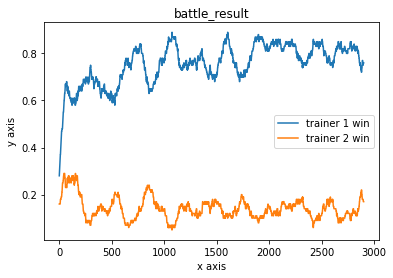

In [451]:
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

win1 = [{0:0,1:1,-1:0}[w] for w in winners] #trainer 1が勝利した要素数
win2 = [{0:0,1:0,-1:1}[w] for w in winners] #trainer 2が勝利した要素数

num=100 #移動平均の個数

b=np.ones(num)/float(num)
y1=np.convolve(win1, b, mode='same')#移動平均
x1  = list(range(len(y1)))

b=np.ones(num)/float(num)
y2=np.convolve(win2, b, mode='same')#移動平均
x2  = list(range(len(y2)))

#y = winners
#x = list(range(len(y)))
#plt.scatter(x, y, label="winner")

plt.plot(x1[:len(x1)-num], y1[:len(y1)-num], label="trainer 1 win")
plt.plot(x2[:len(x2)-num], y2[:len(y2)-num], label="trainer 2 win")

plt.xlabel("x axis")
plt.ylabel("y axis")
plt.title("battle_result")
plt.legend()
plt.show()

### 学習結果
対戦ポケモンのペアによる特徴量の重み=期待値を、大きい順に表示

期待値が大きいほど、その行動を取りやすい

In [455]:

print("Final Action Result")
states = {s for qs in battle_agent1.q.values() for s in qs.keys() if ",Enemy" in s}
for state in sorted(states):
    print(state)
    for action,qs in sorted(battle_agent1.q.items(), key=lambda x: x[1][state], reverse=True):
        if qs[state] != 0.0:
            print("   ",action,qs[state],battle_agent1.N[action][state],battle_agent2.N[action][state],battle_agent3.N[action][state])

    """
    for name,count in winner_count.items():
        print name,"...",
        for n,c in count.items():
            print n,":",c,
        print
    """

    """
    print "Select Result"
    for a,ss in sorted(select_agent1.q.items()):
        print a
        for sk,sv in sorted(ss.items()):
            print sk,select_agent1.N[a][sk],select_agent2.N[a][sk]
    """

#battle_agent1.save("battle_agent1.pkl")

Final Action Result
Me:Null,Enemy:ばけたすがたミミッキュ
    Change_カビゴン 0.02882628164153574 8.0 0 0
    Change_ばけたすがたミミッキュ 0.0005336723550333787 2.0 0 1.0
    Change_ウォッシュロトム 0.00029448836160250204 1.0 0 0
    Change_サザンドラ -0.002026889255551911 3.0 0 0
    Change_ガラルヒヒダルマ -0.002263976197445704 1.0 0 0
    Change_バンギラス -0.0030434751414262816 3.0 0 0
    Change_ニンフィア -0.00470192185778205 1.0 0 0
    Change_ルカリオ -0.005205891623049852 2.0 0 0
    Change_ドリュウズ -0.014253122592480006 4.0 0 0
    Change_ドラパルト -0.016051074775455598 10.0 0 2.0
    Change_アーマーガア -0.06915548422988764 11.0 0 1.0
Me:Null,Enemy:ばれたすがたミミッキュ
    Change_アーマーガア 0.23303171055169553 48.0 0 2.0
    Change_カビゴン 0.11383562092669308 7.0 0 1.0
    Change_ドリュウズ 0.08251413115327587 15.0 0 0
    Change_バンギラス 0.078244420979496 20.0 0 0
    Change_ドラパルト 0.050279815150266374 33.0 0 2.0
    Change_ギャラドス 0.029423125521996434 1.0 0 3.0
    Change_ばけたすがたミミッキュ 0.02517376517487287 2.0 0 0
    Change_ルカリオ 0.018179078281818157 5.0 0 1.0
    Change_ガラル

## breed

In [434]:
breed_agent1.q

defaultdict(<function __main__.ELAgent.__init__.<locals>.<lambda>>,
            {'': defaultdict(float,
                         {'': 0.0,
                          'アーマーガア': 0.0,
                          'カビゴン': 0.0,
                          'ギャラドス': 0.0,
                          'サザンドラ': 0.0,
                          'トゲキッス': 0.0,
                          'ドラパルト': 0.0,
                          'ドリュウズ': 0.0,
                          'ニンフィア': 0.0,
                          'バンギラス': 0.0,
                          'ヒヒダルマ': 0.0,
                          'ミミッキュ': 0.0,
                          'ルカリオ': 0.0,
                          'ロトム': 0.0}),
             0: defaultdict(float,
                         {'': 0.01146007199988357,
                          'アーマーガア': -0.11496978418891313,
                          'カビゴン': 0.2963570698548283,
                          'ギャラドス': 0.1875082102744986,
                          'サザンドラ': 0.04338229003694809,
                          'トゲキッス'